## Imports

In [3]:
import os
import json
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')              #for export
from matplotlib.colors import to_rgb
matplotlib.rcParams['lines.linewidth'] = 2.0

import seaborn as sns
sns.reset_orig()
sns.set()

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data import DataLoader

from tqdm import tqdm



<ipython-input-3-ce6ef53d86c8>:9: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf')              #for export


### I used PyTorch Lightning

In [4]:
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError:
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

### I used tensorboard for visualization

In [5]:
#Tensorboard extension for visualisation purporses
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

### The path for dataset and setting cpu/gpu

In [6]:
# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial9"

#Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device: ", device)

INFO:lightning_fabric.utilities.seed:Seed set to 42


Device:  cuda:0


## Preprocessing Data
Loading dataset, making subsets for training, testing and validation. I could do augmentation. 
Train, test and val loaders.

In [7]:
#transformacija slika u tenzore i normalizacija piksela
# Transformations applied on each image => only make them a tensor
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,))])
#ucitavanje dataseta i podela na trening i validacioni skup
# Loading the training dataset. We need to split it into a training and validation part
train_dataset = CIFAR10(root = DATASET_PATH, train = True, transform = transform, download = True)
pl.seed_everything(42)
train_set, val_set = torch.utils.data.random_split(train_dataset, [45000, 5000])

#ucitavanje testnog skupa
#Loading the test set
test_set = CIFAR10(root=DATASET_PATH, train=False, transform=transform, download=True)

#kreiranje DataLoader za trening set, koji iterira kroz dataset u batch-evima od 256 slika, mesa podatke, igorise poslednji batch ako nije pun. kreira se i data loader i za validacioni skup,e ne mesa podatke i uzima i poslednji batch cak i ako nije pun. ima i test data loader
# We define a set of data loaders that we can use for various purposes later.
train_loader = data.DataLoader(train_set, batch_size = 256, shuffle = True, drop_last = True, pin_memory = True, num_workers = 4)
val_loader = data.DataLoader(val_set, batch_size=256, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=256, shuffle=False, drop_last=False, num_workers=4)


#fja za dobijanje slika za trening, vraca zadati broj slika iz trening seta, stvara batch od num slika iz trening dataseta i spaja slike u jedan tenzor
def get_train_images(num):
    return torch.stack([train_dataset[i][0] for i in range(num)], dim=0)

Files already downloaded and verified


INFO:lightning_fabric.utilities.seed:Seed set to 42


Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Residual Block

In [8]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, mode="unmodified"):
        super().__init__()
        assert mode in ["unmodified", "upsample", "downsample"]
        self.mode = mode
        if mode == "unmodified":
            self.block = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1),
                #nn.InstanceNorm2d(out_channels),
                nn.ReLU()
            )
        elif mode == "upsample":
            self.block = nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
                #nn.InstanceNorm2d(out_channels),
                nn.ReLU()
            )
        elif mode == "downsample":
            self.block = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=2),
                #nn.InstanceNorm2d(out_channels),
                nn.ReLU()
            )

        self.id = nn.Identity()

        if in_channels != out_channels or mode == "downsample":
            self.id = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2 if mode == "downsample" else 1),
            )
        elif mode == "upsample":
            self.id = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        # print(f"ResidualBlock {self.mode} input shape: {x.shape}")
        main_path_out = self.block(x)
        # print(f"ResidualBlock {self.mode} main path out shape: {main_path_out.shape}")
        shortcut_out = self.id(x)
        # print(f"ResidualBlock {self.mode} shortcut out shape: {shortcut_out.shape}")
        if main_path_out.shape != shortcut_out.shape:
            shortcut_out = F.interpolate(shortcut_out, size=main_path_out.shape[2:], mode='nearest')
            # print(f"ResidualBlock {self.mode} adjusted shortcut out shape: {shortcut_out.shape}")
        return main_path_out + shortcut_out

### Residual network that builds Endocer

In [9]:
class ResNetEncoder(nn.Module):
    def __init__(self, in_channels, latent_dim, block_name="ResidualBlock", **kwargs):
        super().__init__()
        self.in_channels = in_channels
        self.create_network(latent_dim)

    def create_network(self, latent_dim):
        self.input_net = nn.Sequential(
            nn.Conv2d(self.in_channels, 32, kernel_size=3, padding=1),
            #nn.InstanceNorm2d(32),
            nn.ReLU()
        )

        self.body_net = nn.Sequential(
            ResidualBlock(in_channels=32, out_channels=64, mode="downsample"),
            ResidualBlock(in_channels=64, out_channels=64),
            #ResidualBlock(in_channels=64, out_channels=64),
            #ResidualBlock(in_channels=64, out_channels=64),

            ResidualBlock(in_channels=64, out_channels=128, mode="downsample"),
            ResidualBlock(in_channels=128, out_channels=128),
            #ResidualBlock(in_channels=128, out_channels=128),
            #ResidualBlock(in_channels=128, out_channels=128),

            ResidualBlock(in_channels=128, out_channels=256, mode="downsample"),
            ResidualBlock(in_channels=256, out_channels=256),
            #ResidualBlock(in_channels=256, out_channels=256),
            #ResidualBlock(in_channels=256, out_channels=256)
        )

        self.output_net = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(256, latent_dim)
        )

    def forward(self, x):
        x = self.input_net(x)
        x = self.body_net(x)
        x = self.output_net(x)
        return x

### ### Residual network that builds Decoder

In [10]:
class ResNetDecoder(nn.Module):
    def __init__(self, out_channels, latent_dim, block_name="ResidualBlock", **kwargs):
        super().__init__()
        self.out_channels = out_channels
        self.create_network(latent_dim)

    def create_network(self, latent_dim):
        self.inverse_output_net = nn.Sequential(
            nn.Linear(latent_dim, 256 * 4 * 4),
            nn.ReLU(),
            nn.Unflatten(dim=-1, unflattened_size=(256, 4, 4))
        )

        self.inverse_body_net = nn.Sequential(
            ResidualBlock(in_channels=256, out_channels=128, mode="upsample"),
            ResidualBlock(in_channels=128, out_channels=128),
            #ResidualBlock(in_channels=128, out_channels=128),
            #ResidualBlock(in_channels=128, out_channels=128),

            ResidualBlock(in_channels=128, out_channels=64, mode="upsample"),
            ResidualBlock(in_channels=64, out_channels=64),
            #ResidualBlock(in_channels=64, out_channels=64),
            #ResidualBlock(in_channels=64, out_channels=64),

            ResidualBlock(in_channels=64, out_channels=32, mode="upsample"),
            ResidualBlock(in_channels=32, out_channels=32),
            #ResidualBlock(in_channels=32, out_channels=32),
            #ResidualBlock(in_channels=32, out_channels=32),
        )

        self.inverse_input_net = nn.Sequential(
            nn.ConvTranspose2d(32, self.out_channels, kernel_size=3, padding=1),
            nn.Tanh()  # or nn.Sigmoid()
        )

    def forward(self, x):
        # print("Decoder input shape:", x.shape)
        x = self.inverse_output_net(x)
        # print("After inverse_output_net:", x.shape)
        x = self.inverse_body_net(x)
        # print("After inverse_body_net:", x.shape)
        x = self.inverse_input_net(x)
        # print("After inverse_input_net:", x.shape)
        return x

### Autoencoder

In [11]:
class Autoencoder(pl.LightningModule):
    def __init__(self, base_channel_size, latent_dim, encoder_class=ResNetEncoder, decoder_class=ResNetDecoder, num_input_channels=3, width=32, height=32):
        super().__init__()
        self.save_hyperparameters()
        self.encoder = encoder_class(num_input_channels, latent_dim)
        self.decoder = decoder_class(num_input_channels, latent_dim)

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

    def _get_reconstruction_loss(self, batch):
        x, _ = batch
        x_hat = self.forward(x)
        loss = F.mse_loss(x, x_hat, reduction="none")
        loss = loss.sum(dim=[1, 2, 3]).mean(dim=[0])
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=20, min_lr=5e-5)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}

    def training_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log('val_loss', loss)

    def test_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log('test_loss', loss)

In [14]:
class GenerateCallback(pl.Callback):

    def __init__(self, input_imgs, every_n_epochs=1):
        super().__init__()
        self.input_imgs = input_imgs # Images to reconstruct during training
        self.every_n_epochs = every_n_epochs # Only save those images every N epochs (otherwise tensorboard gets quite large)

    def on_train_epoch_end(self, trainer, pl_module):
        if trainer.current_epoch % self.every_n_epochs == 0:
            # Reconstruct images
            input_imgs = self.input_imgs.to(pl_module.device)
            with torch.no_grad():
                pl_module.eval()
                reconst_imgs = pl_module(input_imgs)
                pl_module.train()
            # Plot and add to tensorboard
            imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0,1)
            grid = torchvision.utils.make_grid(imgs, nrow=2, normalize=True)
            trainer.logger.experiment.add_image("Reconstructions", grid, global_step=trainer.global_step)

### Training

In [15]:
def train_cifar(latent_dim):
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, f"cifar10_{latent_dim}"),
                         accelerator="gpu" if torch.cuda.is_available() else "cpu",
                         devices=1,
                         max_epochs=50,
                         callbacks=[ModelCheckpoint(save_weights_only=True),
                                    GenerateCallback(get_train_images(8), every_n_epochs=10),
                                    LearningRateMonitor("epoch")])
    trainer.logger._log_graph = True
    trainer.logger._default_hp_metric = None

    pretrained_filename = os.path.join(CHECKPOINT_PATH, f"cifar10_{latent_dim}.ckpt")
    # if os.path.isfile(pretrained_filename):
    #     print("Found pretrained model, loading...")
    #     model = Autoencoder.load_from_checkpoint(pretrained_filename)
    # else:
    model = Autoencoder(base_channel_size=32, latent_dim=latent_dim)
    trainer.fit(model, train_loader, val_loader)
    val_result = trainer.test(model, val_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)
    result = {"test": test_result, "val": val_result}
    return model, result

model, _ = train_cifar(256)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type          | Params | Mode 
--------------------------------------------------
0 | encoder | ResNetEncoder | 1.3 M  | train
1 | decoder | ResNetDecoder | 2.0 M  | train
--------------------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.005    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

### Visualization


Encoding images: 100%|██████████| 175/175 [01:47<00:00,  1.55it/s]
                                                                  
Encoding images:  98%|█████████▊| 39/40 [00:20<00:00,  2.52it/s]
                                                                

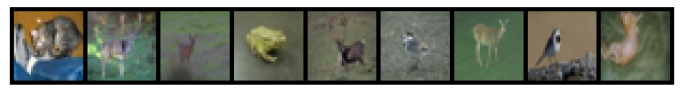

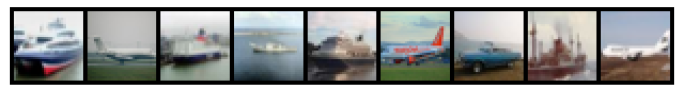

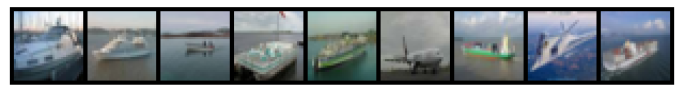

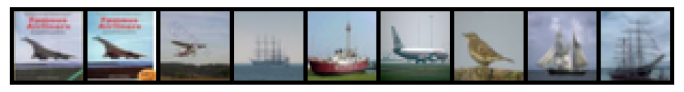

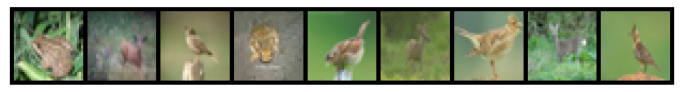

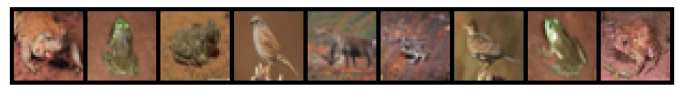

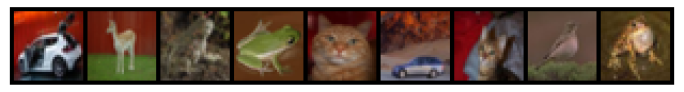

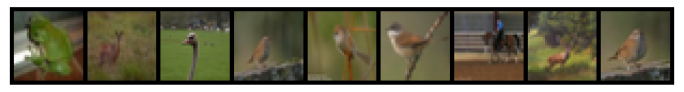

In [16]:
def embed_imgs(model, data_loader):
    img_list, embed_list = [], []
    model.eval()
    for imgs, _ in tqdm(data_loader, desc="Encoding images", leave=False):
        with torch.no_grad():
            z = model.encoder(imgs.to(model.device))
        img_list.append(imgs)
        embed_list.append(z)
    return (torch.cat(img_list, dim=0), torch.cat(embed_list, dim=0))

train_img_embeds = embed_imgs(model, train_loader)
test_img_embeds = embed_imgs(model, test_loader)

def find_similar_images(query_img, query_z, key_embeds, K=8):
    dist = torch.cdist(query_z[None, :], key_embeds[1], p=2)
    dist = dist.squeeze(dim=0)
    dist, indices = torch.sort(dist)
    imgs_to_display = torch.cat([query_img[None], key_embeds[0][indices[:K]]], dim=0)
    grid = torchvision.utils.make_grid(imgs_to_display, nrow=K+1, normalize=True)
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(12, 3))
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

for i in range(8):
    find_similar_images(test_img_embeds[0][i], test_img_embeds[1][i], key_embeds=train_img_embeds)

### Save model

In [17]:
torch.save(model.state_dict(), 'cifarmodel.pth')